# Analysis of the Kohn-Sham driving dataset

## First case: single periodic driving $h_i (t)=0.5J cos(\omega t)+ a_i$

### Dataset analysis

#### Imports

In [7]:
import numpy as np
import matplotlib.pyplot as plt

#### Parameters

In [8]:
data=np.load('data/dataset_h_eff/periodic/dataset_periodic_random_rate_0-1_nbatch_10_batchsize_100_steps_200_tf_20.0_l_8_240307.npz')

z=data['z']
h_eff=data['h_eff']
h=data['h']

time=np.linspace(0,20,h.shape[1])

print(f'ndata={h.shape[0]} \n time steps={h.shape[1]} \n')


ndata=1000 
 time steps=200 



#### Histogram of the values

This procedure has been used in the static DFT case to check which range of values is explored by the magnetization. Remember that the magnetization space can be explored just by varying the driving.

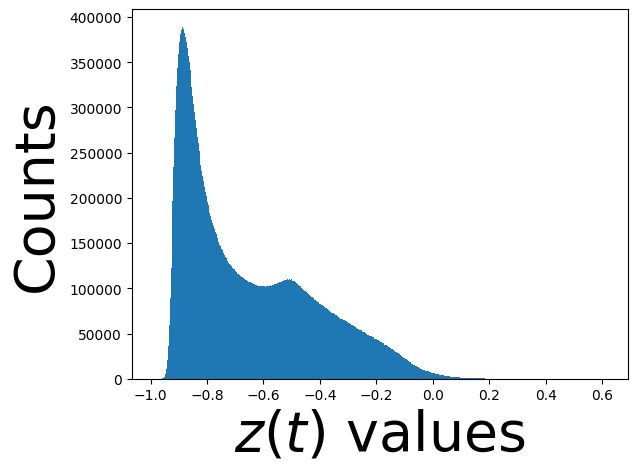

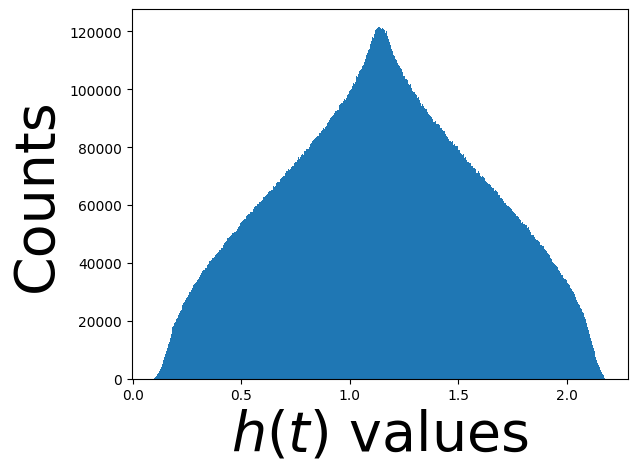

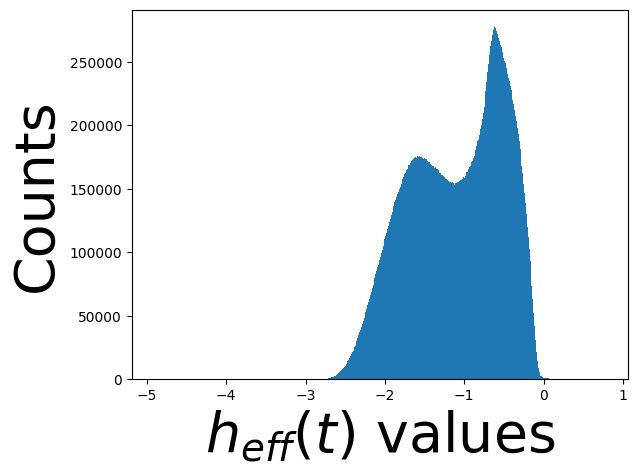

In [11]:
plt.hist(z[:20000].reshape(-1),bins=500)
plt.xlabel(r'$z(t)$ values',fontsize=40)
plt.ylabel('Counts',fontsize=40)
plt.show()

plt.hist(h[:20000].reshape(-1),bins=500)
plt.xlabel(r'$h(t)$ values',fontsize=40)
plt.ylabel('Counts',fontsize=40)
plt.show()

plt.hist(h_eff[:20000].reshape(-1),bins=500)
plt.xlabel(r'$h_{eff}(t)$ values',fontsize=40)
plt.ylabel('Counts',fontsize=40)
plt.show()

#### Random Samples

We want to see some random samples to check the behaviour of the dynamics.

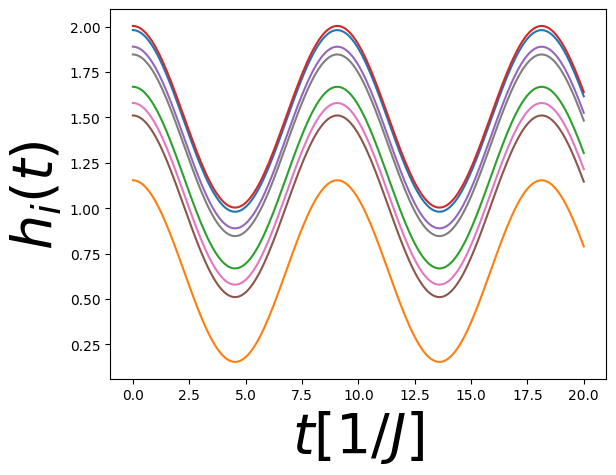

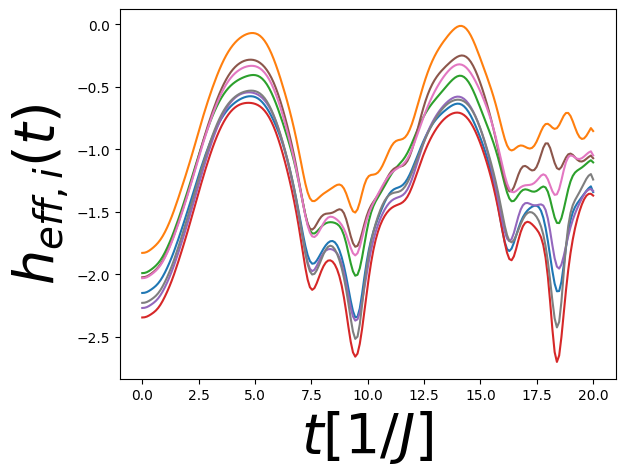

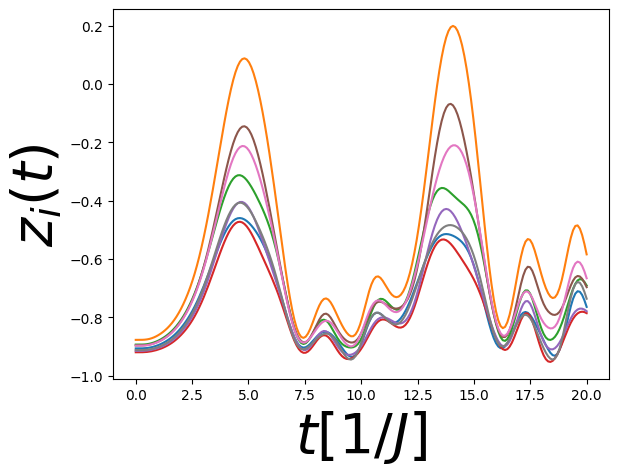

In [4]:
idx=np.random.randint(0,85000)

for i in range(h.shape[-1]):
    plt.plot(time,h[idx,:,i])
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$h_i(t)$',fontsize=40)
plt.show()


for i in range(h.shape[-1]):
    plt.plot(time,h_eff[idx,:,i])
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$h_{eff,i}(t)$',fontsize=40)
plt.show()


for i in range(h.shape[-1]):
    plt.plot(time,z[idx,:,i])
plt.xlabel(r'$t[1/J]$',fontsize=40)
plt.ylabel(r'$z_i(t)$',fontsize=40)
plt.show()

#### Check any NAN in the dataset

The computation of the $h_{eff}(t)$ driving may suffer discontinuous behaviours, due to the rapid evolution of both the magnetization current and the magnetization and due to the small time steps. For this reason we need to double check if NAN values occur.

In [5]:
nan_indices = np.where(np.isnan(h_eff))[0]
print('indices of the samples affected by the NAN=',nan_indices,'\n')


indices of the samples affected by the NAN= [] 



#### Create a puntual $z_i(t) \rightarrow h_{eff,i}(t)-h(t)$ dataset

Following the paper "Machine-learning Kohn–Sham potential from dynamics in time-dependent Kohn–Sham systems" DOI:10.1088/2632-2153/ace8f0 , we create a dataset of punctual mappings between the magnetization and the effective field 

In [6]:
ndata=5000
#we take steps every 20 time steps
z_punctual=z[:ndata,::20].reshape(-1,z.shape[-1])
# we need to fix h_eff-h because our Kohn sham system is fixed by h(t)
h_eff_punctual=(h_eff[:ndata,::20]-h[:ndata,::20]).reshape(-1,z.shape[-1])

#we save the dataset
print('total data=',z_punctual.shape[0],'\n')

np.savez(f'data/dataset_h_eff/train_punctual_dataset_{z_punctual.shape[0]}',density=z_punctual,potential=h_eff_punctual)


total data= 50000 



#### Fourier transform and analysis of the spectrum

It is still unclear how we can map the Kohn-Sham driving to the Many-body dynamics. A possible strategy is to follow the Quantum computer solver in the paper DOI:10.1088/1367-2630/16/8/083035 "Computational complexity of time-dependent density functional theory" and mapping $h(t) \rightarrow h_{eff}(t)$. In order to do that, because we are dealing with continous system, the best approach is via the spectrum analysis. Therefore we investigate the spectrum of these observables and we create a dataset based on this

##### Fourier transform

In [7]:
z_fft=np.fft.fft(z,axis=1,norm='forward')
h_fft=np.fft.fft(h,axis=1,norm='forward')
h_eff_fft=np.fft.fft(h_eff,axis=1,norm='forward')

# we devide the real and imag part in two channels because the model cannot deal with complex values
h_fourier=np.zeros((z_fft.shape[0],2,z_fft.shape[1],z_fft.shape[-1]))
h_fourier[:,0]=np.real(h_fft)
h_fourier[:,1]=np.imag(h_fft)

# we devide the real and imag part in two channels because the model cannot deal with complex values
h_eff_fourier=np.zeros((z_fft.shape[0],2,z_fft.shape[1],z_fft.shape[-1]))
h_eff_fourier[:,0]=np.real(h_eff_fft)
h_eff_fourier[:,1]=np.imag(h_eff_fft)

# we devide the real and imag part in two channels because the model cannot deal with complex values
z_fourier=np.zeros((h_eff.shape[0],2,h_eff.shape[1],h_eff.shape[-1]))
z_fourier[:,0]=np.real(z_fft)
z_fourier[:,1]=np.imag(z_fft)

##### Histogram of the effective field in fourier

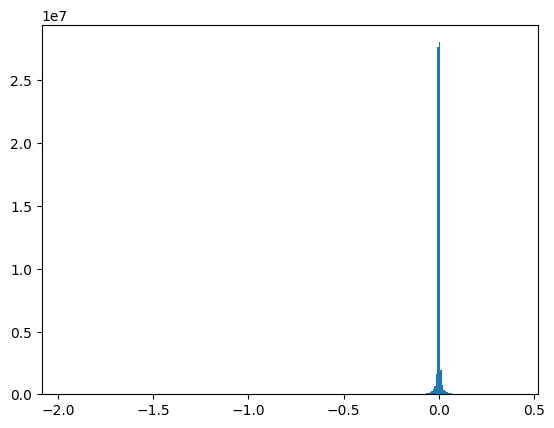

47163216
50937606


In [13]:
plt.hist(h_eff_fourier[:20000].reshape(-1),bins=300)
plt.show()

#we check the range of these values
print(np.argmax(h_eff_fourier[:20000].reshape(-1)))
print(np.argmin(h_eff_fourier[:20000].reshape(-1)))

##### See the spectrum of a random sample

(100000, 2, 200, 8)


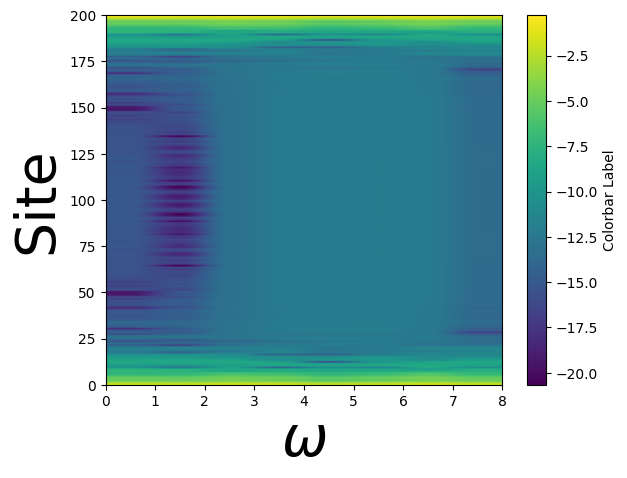

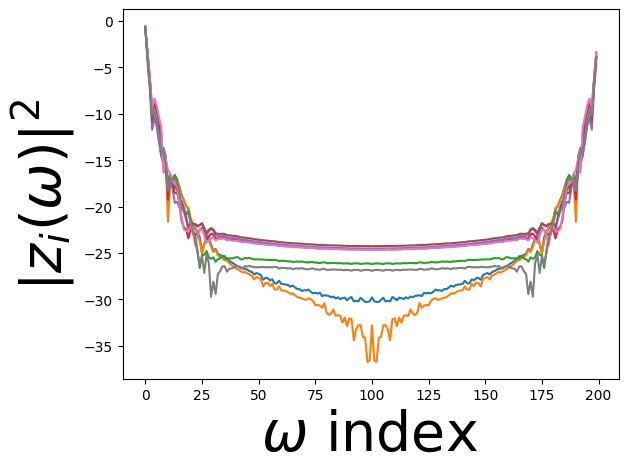

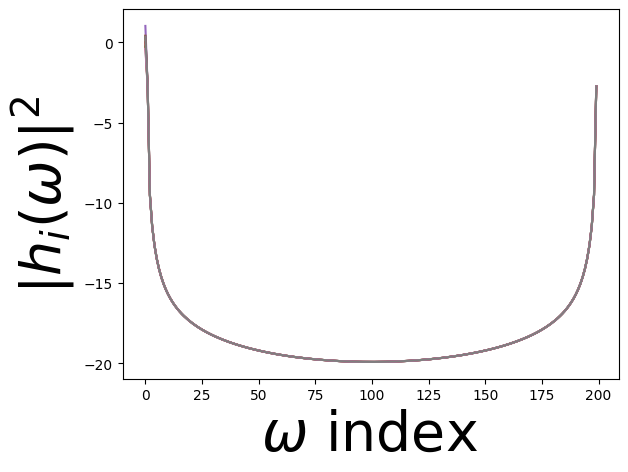

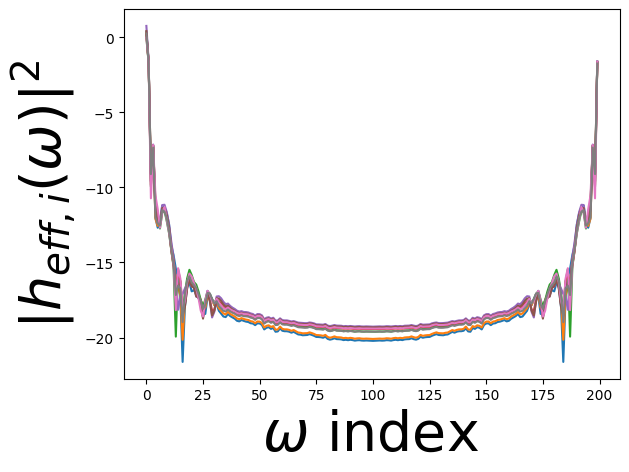

In [7]:


# Create figure and axes
fig, ax = plt.subplots()

# Plot the data
im=ax.imshow(np.log(np.abs(z_fourier[idx,0])), aspect='auto', cmap='viridis', extent=[ 0, 8, 0,200])
print(z_fourier.shape)
# Set labels
ax.set_xlabel(r'$\omega$',fontsize=40)
ax.set_ylabel('Site',fontsize=40)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Colorbar Label')

plt.show()

for i in  range(z_fourier.shape[-1]):
    plt.plot(np.log(z_fourier[idx,0,:,i]**2+z_fourier[idx,1,:,i]**2))
plt.xlabel(r'$\omega$ index ',fontsize=40)
plt.ylabel(r'$|z_i(\omega)|^2$',fontsize=40)
plt.show()

for i in  range(z_fourier.shape[-1]):
    plt.plot(np.log(h_fourier[idx,0,:,i]**2+h_fourier[idx,1,:,i]**2))
plt.xlabel(r'$\omega$ index ',fontsize=40)
plt.ylabel(r'$|h_i(\omega)|^2$',fontsize=40)
plt.show()


for i in  range(z_fourier.shape[-1]):
    plt.plot(np.log(h_eff_fourier[idx,0,:,i]**2+h_eff_fourier[idx,1,:,i]**2))
plt.xlabel(r'$\omega$ index ',fontsize=40)
plt.ylabel(r'$|h_{eff,i}(\omega)|^2$',fontsize=40)
plt.show()



##### Make a dataset based on the Fourier transform

In [8]:
#fix the data
ndata=60000
# fix the file name
file_name=f'train_dataset_fourier_format_240301_ndata_{ndata}'
# permutation
p=np.random.permutation(ndata)
# savez
np.savez('data/dataset_h_eff/'+file_name,density=z_fourier[:ndata][p],potential=h_eff_fourier[:ndata][p],h=h_fourier[:ndata][p])





## Computation of the effective field from the q vector and the R matrix

Our goal is to check if the relation $h_{eff,i}(t)= R^{-1}_{A,ij}(t) ( q_i(t)-q_{A,i}(t)+ R_{ij}(t) h_j(t))$ 

where $q_i(t)=\langle [H_0(t),[H_0(t),Z_i]] \rangle$ and $R_{ij}(t)=\langle [ Z_j, [Z_i,H_0(t)]]\rangle $

#### Imports and Methods

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
from src.qutip_lab.qutip_class import SpinOperator, SpinHamiltonian, SteadyStateSolver
from scipy.fft import fft, ifft
import qutip
from qutip.metrics import fidelity
from typing import List
from qutip import propagator
import os


def generate_smooth_gaussian_noise(
    time: np.ndarray,
    tau: float,
    tf: float,
    mean: float,
    sigma: float,
    min_range: float,
    max_range: float,
    shift: float,
):
    a_omegas = np.random.normal(mean, sigma, size=time.shape[0])
    omegas = np.linspace(0, time.shape[0] * 2 * np.pi / tf, time.shape[0])
    driving = np.zeros(time.shape[0])

    for tr in range(time.shape[0]):
        if omegas[tr] < 2 * np.pi / tau:
            driving = driving + a_omegas[tr] * np.cos(omegas[tr] * time)

        else:
            break

    max_driving = np.max(driving)
    min_driving = np.min(driving)

    old_interval = max_driving - min_driving
    driving = (
        (driving - min_driving) * (max_range - min_range) / old_interval
        + min_range
        + shift
    )

    return driving


class Driving:
    def __init__(self, h: np.array, idx: int, dt: float) -> None:
        self.h = h
        # self.tf=tf
        self.idx: int = idx
        self.dt: float = dt

    def field(self, t: float, args):
        return self.h[int(t / self.dt), self.idx]

    def get_the_field(
        self,
    ):
        return self.h

#### Parameters and Observables

In [89]:
l =8
#rates = [0.1, 0.5, 0.8, 1.0]

rate=1.0
# j coupling
j=-1.
# omega auxiliary field
omega=1
range_h=np.random.uniform(0.6,1.)
#max_h = 1.0 + np.linspace(0.1, 1., nbatch)
#min_h = np.linspace(0.1, 1., nbatch)
hi=np.ones(l)#np.random.uniform(0.1,1,size=l)


steps = 200
tf = 20.0
time = np.linspace(0.0, tf, steps)


ham0 = SpinHamiltonian(
    direction_couplings=[("x", "x")],
    pbc=True,
    coupling_values=[j],
    size=l,
)

obs: List[qutip.Qobj] = []
current_obs: List[qutip.Qobj] = []
q_obs: List[qutip.Qobj]=[]
r_diag_obs: List[qutip.Qobj]=[]
r_diag_plus_obs: List[qutip.Qobj]=[]
r_diag_minus_obs:List[qutip.Qobj]=[]
for i in range(l):
    z_op = SpinOperator(index=[("z", i)], coupling=[1.0], size=l, verbose=1)
    # print(f"x[{i}]=", x.qutip_op, "\n")
    current = SpinOperator(
        index=[("x", (i-1)%l, "y", i), ("y", i, "x", (i + 1) % l)],
        coupling=[2*j, 2*j],
        size=l,
    )
    q = SpinOperator(
        index=[("x", (i - 1) % l, "z", i,"x",(i+1)%l)],
        coupling=[2*j**2],
        size=l,
    )
    r_diag=SpinOperator(
        index=[("x", (i - 1) % l, "x", i), ("x", i, "x", (i + 1) % l)],
        coupling=[j, j],
        size=l,
    )
    r_diag_plus=SpinOperator(
        index=[ ("y", i, "y", (i+1)%l)],
        coupling=[-j, -j],
        size=l,
    )
    r_diag_minus=SpinOperator(
        index=[ ("y", (i-1)%l, "y", i )],
        coupling=[-j, -j],
        size=l,
    )
    
    if i==0:
        print(q.qutip_op)
    
    
    obs.append(z_op.qutip_op)
    current_obs.append(current.qutip_op)
    q_obs.append(q.qutip_op)
    r_diag_obs.append(r_diag.qutip_op)
    r_diag_minus_obs.append(r_diag_minus.qutip_op)
    r_diag_plus_obs.append(r_diag_plus.qutip_op)
    
# set the external driving
h=0.5*np.cos(time*rate)[:,None]+hi[None,:]

hamExtZ = SpinOperator(
                index=[("z", i) for i in range(l)], coupling=h[0], size=l
            )


# initial state from the ground state of H(0)
eng, psi0 = np.linalg.eigh(ham0.qutip_op + hamExtZ.qutip_op)
psi0 = qutip.Qobj(
    psi0[:, 0], shape=psi0.shape, dims=([[2 for i in range(l)], [1]])
)

print("real ground state energy=", eng[0])

# build up the time dependent object for the qutip evolution
hamiltonian = [ham0.qutip_op]

# set the qutip driving
for i in range(l):
    drive_z = Driving(
        h=h,
        dt=time[1] - time[0],
        idx=i,
    )

    hamiltonian.append([obs[i], drive_z.field])


Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2]], shape = (256, 256), type = oper, isherm = True
Qobj data =
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
real ground state energy= -13.385005233150757


#### Evolution 

In [90]:
output = qutip.sesolve(hamiltonian, psi0, time, e_ops=obs + current_obs+ q_obs + 
                                   r_diag_obs+r_diag_minus_obs+r_diag_plus_obs)

current_exp = np.zeros((steps, l))
z_exp = np.zeros_like(current_exp)
q_exp = np.zeros_like(current_exp)
r_diag_exp = np.zeros_like(current_exp)
r_diag_minus_exp=np.zeros_like(current_exp)
r_diag_plus_exp= np.zeros_like(current_exp)
for r in range(l):
    z_exp[:, r] = output.expect[r]
    current_exp[:, r] = output.expect[l + r]
    q_exp[:,r]=output.expect[2*l+r]+2*output.expect[r]* j**2 #the 2 in the first one is already implemented
    r_diag_exp[:,r]=output.expect[3*l+r]
    r_diag_minus_exp[:,r]=output.expect[4*l+r]
    r_diag_plus_exp[:,r]=output.expect[5*l+r]

Build up the R matrix from the diagonal terms

In [91]:
r_matrix_1=np.einsum('ij,tj->tij',np.eye(r_diag_exp.shape[-1]),r_diag_exp)
print(r_matrix_1[0,:2,:2])
# +1 off diagonal term
r_matrix_2=np.einsum('ij,tj->tij',np.eye(r_diag_exp.shape[-1]),r_diag_plus_exp)
r_matrix_2=np.roll(r_matrix_2,axis=-1,shift=1)
#-1 off diagonal term
r_matrix_3=np.einsum('ij,tj->tij',np.eye(r_diag_exp.shape[-1]),r_diag_minus_exp)
r_matrix_3=np.roll(r_matrix_3,axis=-1,shift=-1)

#sum of all this term
r_matrix=r_matrix_3+r_matrix_2+r_matrix_1

print(r_matrix.shape)
print(r_matrix[0])

#compute the effective field
x_sp = np.sqrt(1 - z_exp**2) * np.cos(
    np.arcsin(-1 * (current_exp) /  (2 * np.sqrt(1 - z_exp**2) ) )
)

x_sp_new=np.sqrt(1 - z_exp**2) * np.cos(
    np.arcsin( (current_exp) /  (np.sqrt(1 - z_exp**2) ) )
)
current_derivative = np.gradient(current_exp, time, axis=0)


h_eff = (0.25 * current_derivative + z_exp) / (x_sp+10**-4 )
#h_eff = ((1/(omega)) * current_exp + z_exp) / (x_sp + 10**-4)


[[-0.72939373  0.        ]
 [ 0.         -0.72939373]]
(200, 8, 8)
[[-0.72939373 -0.26888244  0.          0.          0.          0.
   0.         -0.26888244]
 [-0.26888244 -0.72939373 -0.26888244  0.          0.          0.
   0.          0.        ]
 [ 0.         -0.26888244 -0.72939373 -0.26888244  0.          0.
   0.          0.        ]
 [ 0.          0.         -0.26888244 -0.72939373 -0.26888244  0.
   0.          0.        ]
 [ 0.          0.          0.         -0.26888244 -0.72939373 -0.26888244
   0.          0.        ]
 [ 0.          0.          0.          0.         -0.26888244 -0.72939373
  -0.26888244  0.        ]
 [ 0.          0.          0.          0.          0.         -0.26888244
  -0.72939373 -0.26888244]
 [-0.26888244  0.          0.          0.          0.          0.
  -0.26888244 -0.72939373]]


Bulid up the effective field from these observables

In [92]:
r_h=np.einsum('tji,ti->tj',r_matrix,h)#+np.einsum('tji,ti->ti',r_matrix,h))

q_effective=r_h-current_derivative/4

# definition of the heff from observables
h_eff_from_observables=(z_exp+(r_h-q_effective))/(x_sp+10**-4)

print(h_eff_from_observables.shape)


(200, 8)


Plot the comparison

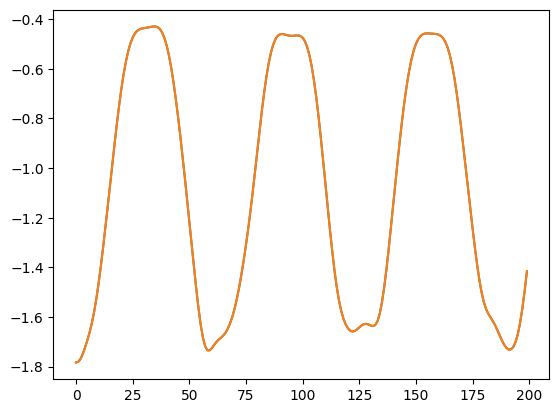

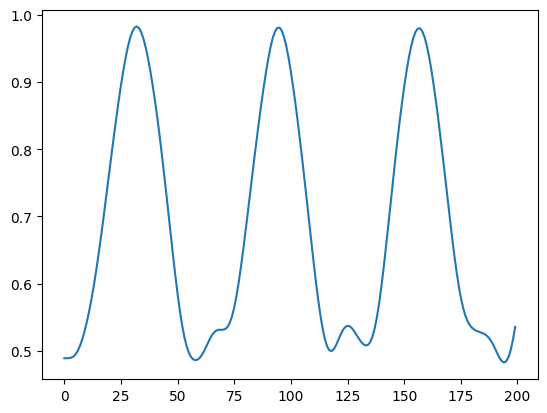

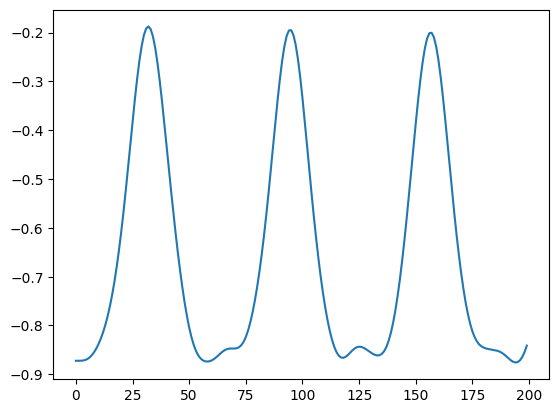

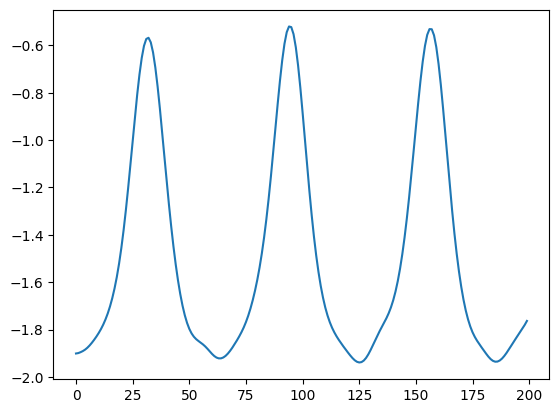

In [93]:
site=1
plt.plot(h_eff[:,site])
plt.plot(h_eff_from_observables[:,site])
plt.show()

plt.plot(x_sp[:,site])
plt.show()

plt.plot(z_exp[:,site])
plt.plot()
plt.show()

plt.plot(q_effective[:,site])
plt.plot()
plt.show()

#### Test the effective field in the non-interacting Hamiltonian

In [39]:
steps = 200
tf = 20.0
time = np.linspace(0.0, tf, steps)


ham0 = SpinOperator(
                index=[("x", i) for i in range(l)], coupling=[1.0]*l, size=l
            )

obs: List[qutip.Qobj] = []
for i in range(l):
    z_op = SpinOperator(index=[("z", i)], coupling=[1.], size=l, verbose=1)
    # print(f"x[{i}]=", x.qutip_op, "\n")
    obs.append(z_op.qutip_op)
    



psi0 = np.zeros((2,l))
psi0[0] = np.sqrt((1 + z_exp[0, :]) / 2)
psi0[1] = np.sqrt((1 - z_exp[0, :]) / 2)

for i in range(l):

    if i==0:
        phi0=psi0[:,i]
    else:
        phi0=np.kron(phi0,psi0[:,i])    

psi0 = qutip.Qobj(phi0, shape=phi0.shape, dims=([[2 for i in range(l)], [1]]))

hamiltonian = [ham0.qutip_op]

for i in range(l):
    drive_z = Driving(
        h=h_eff,
        dt=time[1] - time[0],
        idx=i,
    )

    hamiltonian.append([obs[i], drive_z.field])

            # evolution and

output = qutip.sesolve(hamiltonian, psi0, time, e_ops=obs)


z_exp_effective = np.zeros_like(current_exp)
for r in range(l):
    z_exp_effective[:, r] = output.expect[r]


Comparison of the magnetization evolution

In [ ]:
for i in range(i):
    plt.plot(time,z_exp_effective[:,i])
    plt.plot(time,z_exp[:,i])
    #plt.plot(time,h_eff_from_observables[:,i])
    plt.show()



## Analysis of the Dataset of the R and Q observables

#### Imports

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
from src.qutip_lab.qutip_class import SpinOperator, SpinHamiltonian, SteadyStateSolver
from scipy.fft import fft, ifft
import qutip
from qutip.metrics import fidelity
from typing import List
from qutip import propagator
import os

#### Data

In [95]:
data=np.load('data/dataset_h_eff/periodic/dataset_periodic_random_rate_0-1_nbatch_10_batchsize_100_steps_200_tf_20.0_l_8_240326.npz')

q=data['q']
r_diag=data['r_diag']
r_diag_plus=data['r_diag_plus']
r_diag_minus=data['r_diag_minus']
z=data['z']

h_eff=data['h_eff']
h_eff_from_observables=data['h_eff_from_observables']



#### Analysis of the Input (magnetization $z$)

(1000, 200, 8)


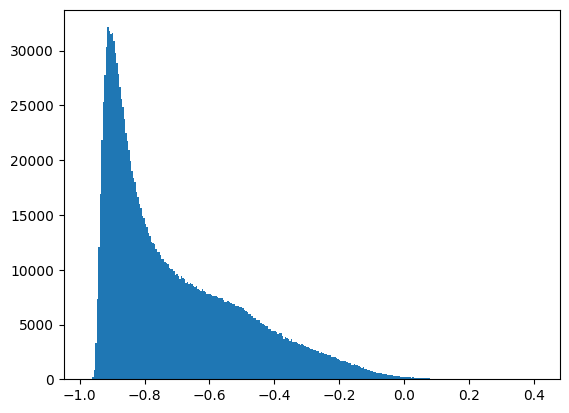

In [96]:
print(z.shape)

plt.hist(z.reshape(-1),bins=300)
plt.show()

#### Analysis of the Outputs (R terms and Q)

(1000, 200, 8)


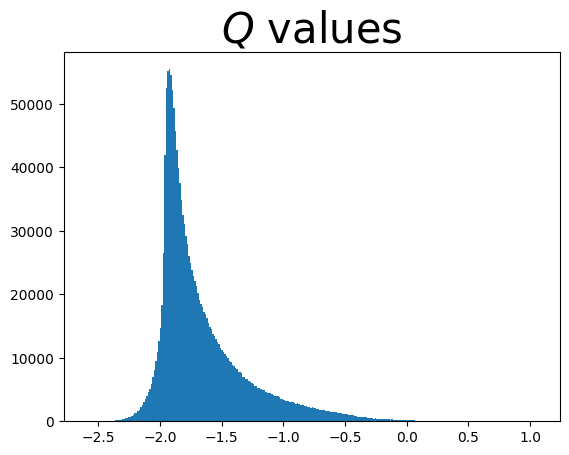

(1000, 200, 8)


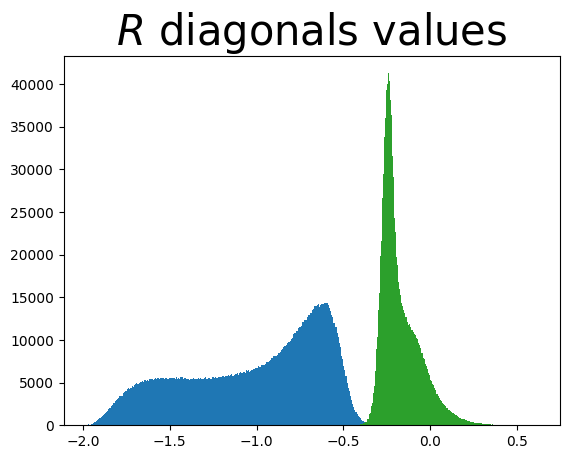

(1000, 200, 8)


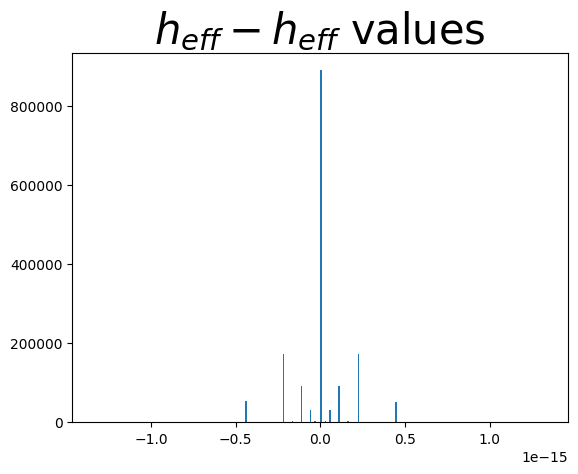

In [98]:
print(q.shape)

plt.hist(q.reshape(-1),bins=300)
plt.title(r'$Q$ values',fontsize=30)
plt.show()

print(r_diag.shape)

plt.hist(r_diag.reshape(-1),bins=300)
plt.hist(r_diag_plus.reshape(-1),bins=300)
plt.hist(r_diag_minus.reshape(-1),bins=300)

plt.title(r'$R$ diagonals values',fontsize=30)
plt.show()

print(h_eff_from_observables.shape)

plt.hist((h_eff-h_eff_from_observables).reshape(-1),bins=300)
plt.title(r'$h_{eff}-h_{eff}$ values',fontsize=30)
plt.show()

#### Create a Dataset for the puntual training

In [101]:
z_punctual=z[:,::20,:].reshape(-1,z.shape[-1])
q_punctual=q[:,::20,:].reshape(-1,z.shape[-1])
r_diag_punctual=r_diag[:,::20,:].reshape(-1,z.shape[-1])
r_diag_plus_punctual=r_diag_plus[:,::20,:].reshape(-1,z.shape[-1])
r_diag_minus_punctual=r_diag_minus[:,::20,:].reshape(-1,z.shape[-1])

output=np.zeros((z_punctual.shape[0],4,z_punctual.shape[-1]))

p=np.random.permutation(output.shape[0])

output[:,0]=q_punctual
output[:,1]=r_diag_punctual
output[:,2]=r_diag_plus_punctual
output[:,3]=r_diag_minus_punctual
print(z_punctual.shape)

np.savez(f'data/dataset_h_eff/train_dataset_punctual_periodic_driving_{z_punctual.shape[0]}',density=z_punctual[p],F_density=output[p])


(10000, 8)


#### Test the neural network